In [1]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
import matplotlib.pyplot as plt

## Dataset Maker

In [2]:
fake = Faker()
Faker.seed(12345)
random.seed(12345)

# Define format of the data we would like to generate
FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

# change this if you want it to work with another language
LOCALES = ['en_US']

In [3]:
def load_date():
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US') # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()
        
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

def load_dataset(m):    
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30
    

    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], 
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

## Prepare Dataset

In [ ]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    
    X, Y = zip(*dataset)
    
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
    
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))



    return X, np.array(Y), Xoh, Yoh

def string_to_int(string, length, vocab):    
    #make lower to standardize
    string = string.lower()
    string = string.replace(',','')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    #print (rep)
    return rep


def int_to_string(ints, inv_vocab):
    l = [inv_vocab[i] for i in ints]
    return l

In [5]:
# gernerate a dataset with m examples
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 24614.07it/s]


In [6]:
# show the first 10 examples
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('monday august 19 2024', '2024-08-19'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('22 may 1988', '1988-05-22'),
 ('8 jul 2008', '2008-07-08'),
 ('wednesday september 8 1999', '1999-09-08')]

In [7]:
# Find the maximum length of the human readable strings
max(len(item[0]) for item in dataset)

27

In [8]:
# show the human vocabulary
human_vocab

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34,
 '<unk>': 35,
 '<pad>': 36}

In [9]:
# show the machine vocabulary
machine_vocab

{'-': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

In [10]:
# show the inverse machine vocabulary
inv_machine_vocab

{0: '-',
 1: '0',
 2: '1',
 3: '2',
 4: '3',
 5: '4',
 6: '5',
 7: '6',
 8: '7',
 9: '8',
 10: '9'}

In [11]:
Tx = 30 # predefine value for length of the human readable strings (since maximum is 27)
Ty = 10 # output length


# X: Original X Data Converted into Numbers using Human_Vocab
# Y: Original Y Data Converted into Numbers using Machine_Vocab
# X_oh: One hot encoded values for converted X dataset
# Y_oh: One hot encoded values for converted Y dataset
X, Y, X_ohe, Y_ohe = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", X_ohe.shape)
print("Yoh.shape:", Y_ohe.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [12]:
X[:1], Y[:1], X_ohe[:1], Y_ohe[:1]

(array([[12,  0, 24, 13, 34,  0,  4, 12, 12, 11, 36, 36, 36, 36, 36, 36,
         36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]]),
 array([[ 2, 10, 10,  9,  0,  1,  6,  0,  1, 10]]),
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.]]], dtype=float32),
 array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.

In [13]:
#One example
index = 0
print("Original date:", dataset[index][0])
print("Target date:", dataset[index][1])

print("Original after preprocessing:", X[index])
print("Target after preprocessing:\n", Y[index])

print("Original one hot encoded:", X_ohe[index])
print("Target one hot encoded:", Y_ohe[index])

Original date: 9 may 1998
Target date: 1998-05-09
Original after preprocessing: [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing:
 [ 2 10 10  9  0  1  6  0  1 10]
Original one hot encoded: [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target one hot encoded: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [14]:
X[index].shape, Y[index].shape, X_ohe[index].shape, Y_ohe[index].shape 

((30,), (10,), (30, 37), (10, 11))

## Calculate the Attention

According to the research paper [*Neural Machine Translation by Jointly Learning to Align and Translate*](https://arxiv.org/abs/1409.0473), the context vector \( c_i \) is obtained using the following equation:

$$
c_i = \sum_{j=1}^{T_x} \alpha_{ij} h_j
$$

where \( \alpha_{ij} \) represents the attention weight assigned to the annotation \( h_j \), computed as:

$$
\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{T_x} \exp(e_{ik})}
$$

Here, \( e_{ij} \) is referred to as the **energy score**, and it is defined as:

$$
e_{ij} = a(s_{i-1}, h_j)
$$

The energy score \( e_{ij} \) is produced by an alignment model \( a(\cdot) \), which measures how well the input at position \( j \) aligns with the output at position \( i \). It depends on the decoder’s previous hidden state \( s_{i-1} \) and the annotation \( h_j \) from the encoder.


In [15]:
# Activation function for attention mechanism
def softmax(x, axis=1):    
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [16]:
repeator = RepeatVector(Tx)                                 # Repeat the input vector Tx times
Concatenator = Concatenate(axis=-1)                         # Concatenate the input vector with the context vector
Densor = Dense(10,activation='tanh')                       # Dense layer to transform the concatenated vector
Densor2 = Dense(1, activation='relu')                       # Dense layer to transform the concatenated vector to a single value
activator = Activation(softmax, name='attention_weights')   # Softmax activation function to normalize the attention weights
dotor = Dot(axes=1)

In [17]:
# get attetion output
def get_attention(a, s_prev):
    s_prev = repeator(s_prev)           # Repeat the previous state vector Tx times
    concat = Concatenator([a, s_prev])  # Concatenate the input vector with the context vector
    e = Densor(concat)                  # Transform the concatenated vector
    energies = Densor2(e)               # Transform the concatenated vector to a single value
    alphas = activator(energies)        # Normalize the attention weights
    context = dotor([alphas, a])        # Compute the context vector
    return context  

In [20]:
n_d = 64  # Number of units in the LSTM layer (decoder)
decoder_LSTM = LSTM(n_d, return_state = True) #decoder one unit
output_layer = Dense(len(machine_vocab), activation=softmax) # decoder output one unit

## Build the Model

In [29]:
def model(Tx=30, Ty=10, n_e=64, n_d=128, human_vocab_size=None):
    X = Input(shape=(Tx, human_vocab_size), name='X') # Input layer for the human readable strings
    s0 = Input(shape=(n_d,), name='s0')  # Initial state for the LSTM
    c0 = Input(shape=(n_d,), name='c0')  # Initial cell
    s = s0
    c = c0
    a = Bidirectional(LSTM(n_e, return_sequences=True, name='bidirectional_lstm'))(X)  # Bidirectional LSTM layer
    outputs = []

    for t in range(Ty):
        context = get_attention(a, s)  # Compute the context vector
        _, s, c = decoder_LSTM(context, initial_state=[s, c])
        out = output_layer(s)
        outputs.append(out)

    model = Model(inputs=[X, s0, c0], outputs=outputs)  # Create the model
    return model

In [30]:
# Tx = 30 
# Ty = 10
n_e = 32
model = model(Tx, Ty, n_e, n_d, len(human_vocab))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X (InputLayer)                 [(None, 30, 37)]     0           []                               
                                                                                                  
 s0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 30, 64)      17920       ['X[0][0]']                      
 )                                                                                                
                                                                                                  
 repeat_vector (RepeatVector)   (None, 30, 64)       0           ['s0[0][0]',               

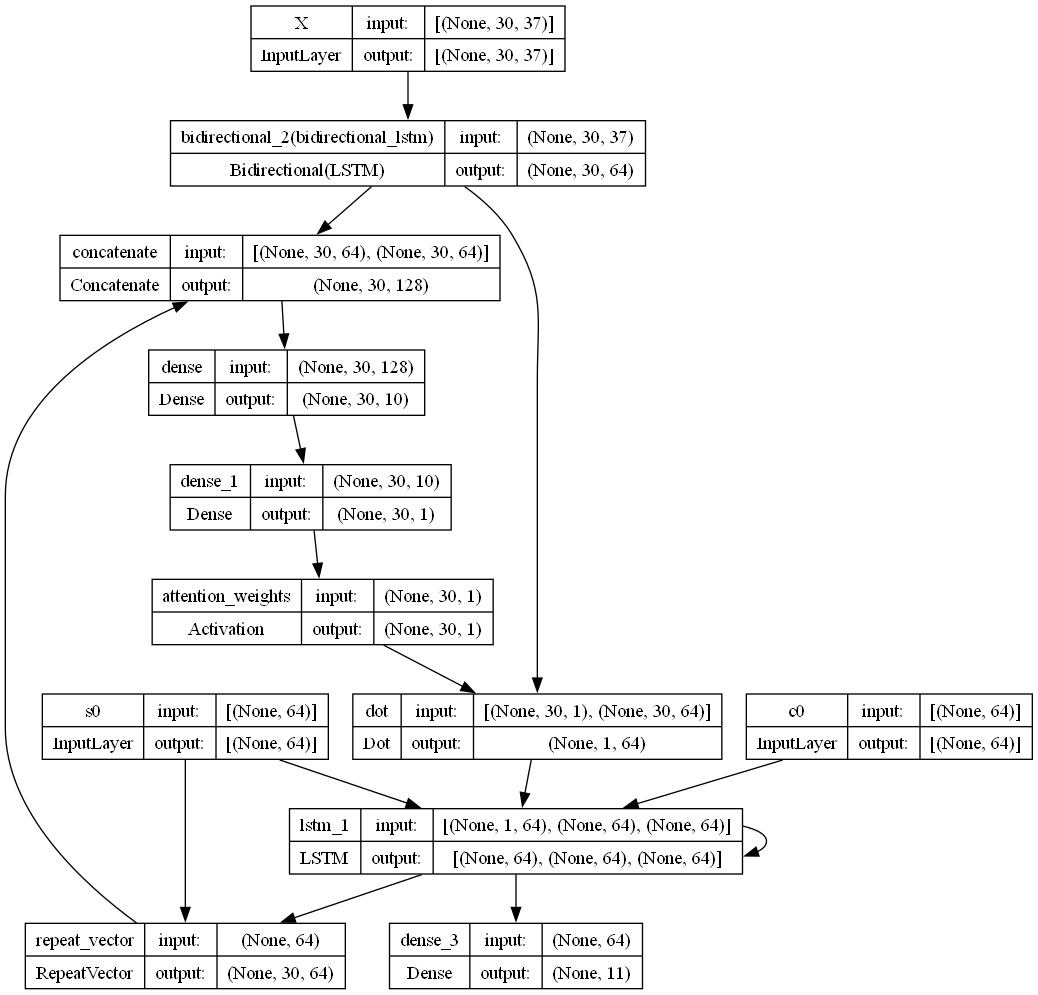

In [31]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [33]:
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [34]:
s0 = np.zeros((m, n_d))
c0 = np.zeros((m, n_d))
outputs = list(Y_ohe.swapaxes(0, 1))  # Swap axes to match the model output format

## Train the model

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# callbacks = [
#     EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1),
#     ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, verbose=1),
#     ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
# ]

history = model.fit([X_ohe, s0, c0], outputs, 
                      epochs=500, 
                      batch_size=100, 
                      #callbacks=callbacks
                      )


Epoch 1/500
100/100 [==============================] - 20s 43ms/step - loss: 16.3694 - dense_3_loss: 1.0746 - dense_3_1_loss: 0.9883 - dense_3_2_loss: 1.7651 - dense_3_3_loss: 2.6475 - dense_3_4_loss: 0.8059 - dense_3_5_loss: 1.2859 - dense_3_6_loss: 2.6468 - dense_3_7_loss: 0.9413 - dense_3_8_loss: 1.6698 - dense_3_9_loss: 2.5442 - dense_3_accuracy: 0.5734 - dense_3_1_accuracy: 0.7367 - dense_3_2_accuracy: 0.2868 - dense_3_3_accuracy: 0.0860 - dense_3_4_accuracy: 0.8872 - dense_3_5_accuracy: 0.3432 - dense_3_6_accuracy: 0.0554 - dense_3_7_accuracy: 0.8889 - dense_3_8_accuracy: 0.3009 - dense_3_9_accuracy: 0.1153
Epoch 2/500
100/100 [==============================] - 4s 40ms/step - loss: 8.7627 - dense_3_loss: 0.1366 - dense_3_1_loss: 0.1348 - dense_3_2_loss: 1.0792 - dense_3_3_loss: 2.0461 - dense_3_4_loss: 0.0159 - dense_3_5_loss: 0.3307 - dense_3_6_loss: 1.9216 - dense_3_7_loss: 0.0163 - dense_3_8_loss: 1.0014 - dense_3_9_loss: 2.0801 - dense_3_accuracy: 0.9669 - dense_3_1_accuracy:

## Make Plots for Losses and Accuracies

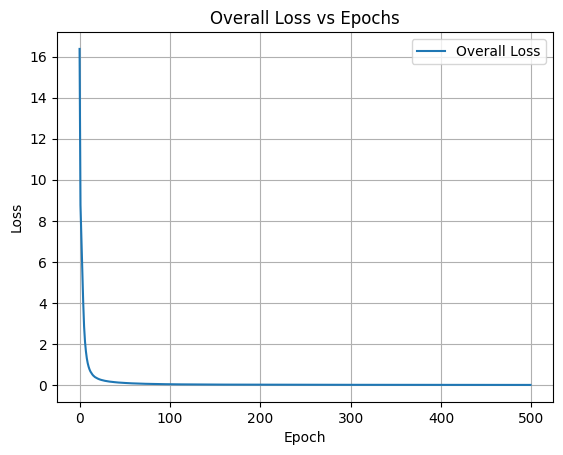

In [36]:
# Plotting the training loss
plt.plot(history.history['loss'], label='Overall Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overall Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

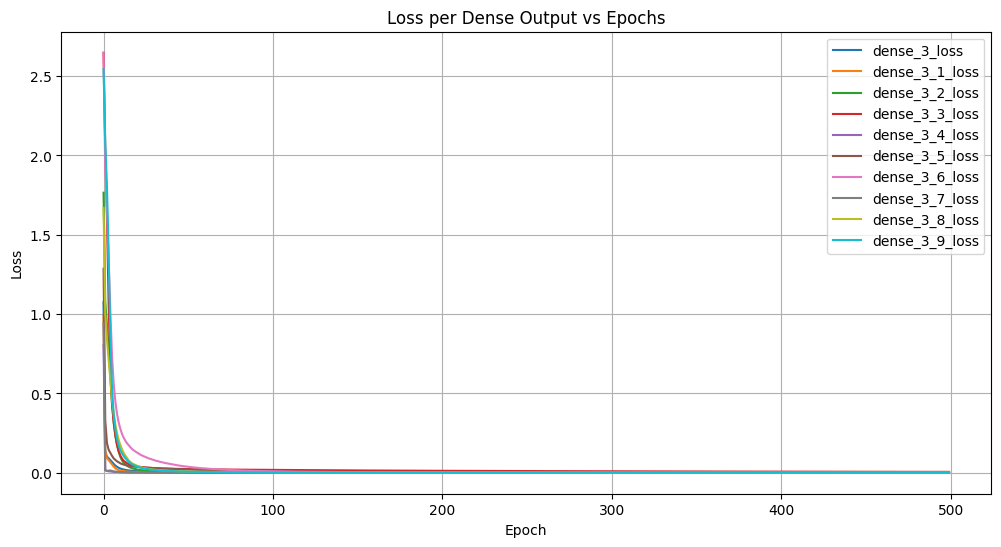

In [37]:
# Plotting the loss for each dense output

dense_losses = [key for key in history.history if 'loss' in key and key != 'loss']

plt.figure(figsize=(12, 6))
for key in dense_losses:
    plt.plot(history.history[key], label=key)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Dense Output vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

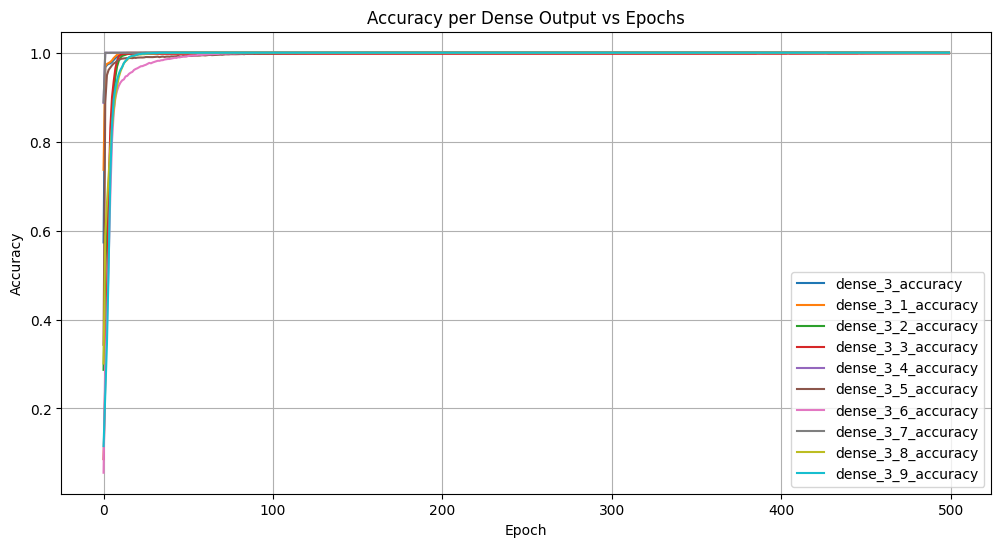

In [38]:
# Plotting the accuracy for each dense output

dense_accuracies = [key for key in history.history if 'accuracy' in key]

plt.figure(figsize=(12, 6))
for key in dense_accuracies:
    plt.plot(history.history[key], label=key)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Dense Output vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Test the Model

In [59]:
EXAMPLES = [
    "Feb 14, 1996",
    "the 5th of June 1990",
    "Monday, 1 Jan 2024",
    "4th of July in 76",
    "December 31st 2020",
    "07 Sept 1985",
    "August 29th, 99",
    "1st of Nov 2015",
    "Sun 6 Feb 2022",
    "17th March in 85",
    "November 2nd, 2000",
    "Jan 1st 70",
    "2 April 22",
    "Wednesday, 3rd March 2021",
    "10 Jul, 2007",
    "Saturday 5th of October 2019",
    "Sept 12th 2003",
    "3rd of May in 79",
    "5 Ap 2009"
]
s00 = np.zeros((1, n_d))
c00 = np.zeros((1, n_d))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output),"\n")

1/1 [==============================] - 0s 63ms/step
source: Feb 14, 1996
output: 1996-02-14 

1/1 [==============================] - 0s 63ms/step
source: the 5th of June 1990
output: 1990-06-02 

1/1 [==============================] - 0s 66ms/step
source: Monday, 1 Jan 2024
output: 2024-01-01 

1/1 [==============================] - 0s 59ms/step
source: 4th of July in 76
output: 1976-06-06 

1/1 [==============================] - 0s 59ms/step
source: December 31st 2020
output: 2020-12-30 

1/1 [==============================] - 0s 64ms/step
source: 07 Sept 1985
output: 1985-09-07 

1/1 [==============================] - 0s 66ms/step
source: August 29th, 99
output: 1999-08-08 

1/1 [==============================] - 0s 65ms/step
source: 1st of Nov 2015
output: 2015-01-01 

1/1 [==============================] - 0s 66ms/step
source: Sun 6 Feb 2022
output: 2022-06-06 

1/1 [==============================] - 0s 60ms/step
source: 17th March in 85
output: 1985-03-01 

1/1 [==================

## Draw Attention Output

In [58]:
def plot_attention_map(modelx, input_vocabulary, inv_output_vocabulary, text, n_s=128, num=7):
    attention_map = np.zeros((10, 30))
    
    Ty, Tx = attention_map.shape
    human_vocab_size = len(input_vocabulary)

    # Input layers
    X = modelx.inputs[0]
    s0 = modelx.inputs[1]
    c0 = modelx.inputs[2]
    s = s0
    c = s0

    # Attention and decoding layers
    a = modelx.layers[2](X)
    outputs = []

    for t in range(Ty):
        s_prev = s
        s_prev = modelx.layers[3](s_prev)
        concat = modelx.layers[4]([a, s_prev])
        e = modelx.layers[5](concat)
        energies = modelx.layers[6](e)
        alphas = modelx.layers[7](energies)
        context = modelx.layers[8]([alphas, a])
        s, _, c = modelx.layers[10](context, initial_state=[s, c])
        outputs.append(energies)

    # Build attention model
    f = Model(inputs=[X, s0, c0], outputs=outputs)

    # Encode input
    s0_val = np.zeros((1, n_s))
    c0_val = np.zeros((1, n_s))
    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, Tx))
    encoded = np.array([to_categorical(x, num_classes=human_vocab_size) for x in encoded[0]])
    encoded = np.array(encoded).reshape((1, Tx, human_vocab_size))

    # Get attention weights
    r = f.predict([encoded, s0_val, c0_val])

    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0, t_prime]

    # Normalize attention map
    row_max = attention_map.max(axis=1)
    attention_map = attention_map / row_max[:, None]

    # Make prediction
    prediction = modelx.predict([encoded, s0_val, c0_val])
    predicted_text = [int(np.argmax(prediction[i], axis=1)) for i in range(len(prediction))]
    predicted_text_str = int_to_string(predicted_text, inv_output_vocabulary)
    predicted_text_str = ''.join(predicted_text_str).replace('<pad>', '').replace('<unk>', '')
    
    

    # Prepare plotting labels
    text_ = list(text)
    input_length = len(text_)
    output_length = Ty

    # --- Plot ---
    plt.clf()
    f = plt.figure(figsize=(8, 6))
    f.suptitle(f'Input: "{text}"  →  Output: "{predicted_text_str}"', fontsize=12)

    ax = f.add_subplot(1, 1, 1)
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # Add colorbar below plot
    cbar = f.colorbar(i, ax=ax, orientation='horizontal', pad=0.15)
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=5)

    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text_str[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')
    ax.grid()

    # Tight layout to remove whitespace
    f.tight_layout()
    f.subplots_adjust(top=0.88)

    return attention_map


1/1 [==============================] - 0s 57ms/step


<Figure size 640x480 with 0 Axes>

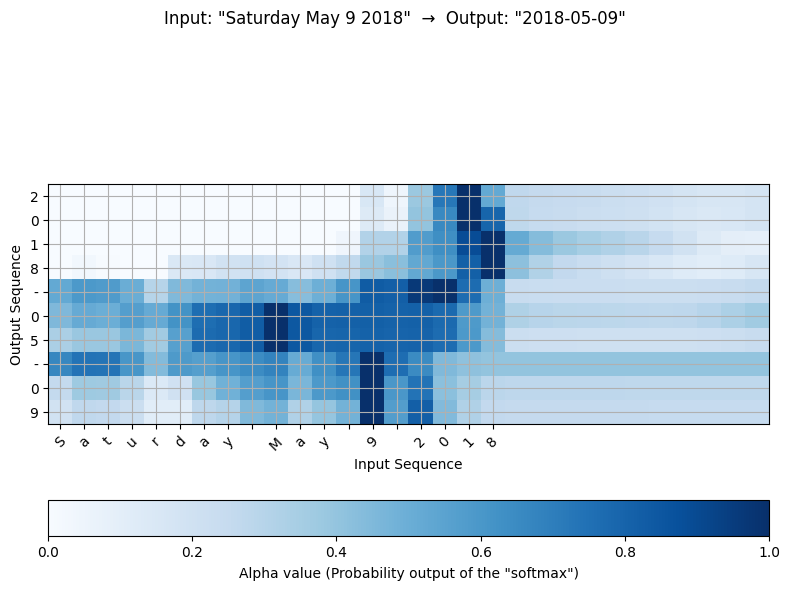

In [52]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Saturday May 9 2018", num = 7, n_s = 64)

1/1 [==============================] - 0s 56ms/step


<Figure size 640x480 with 0 Axes>

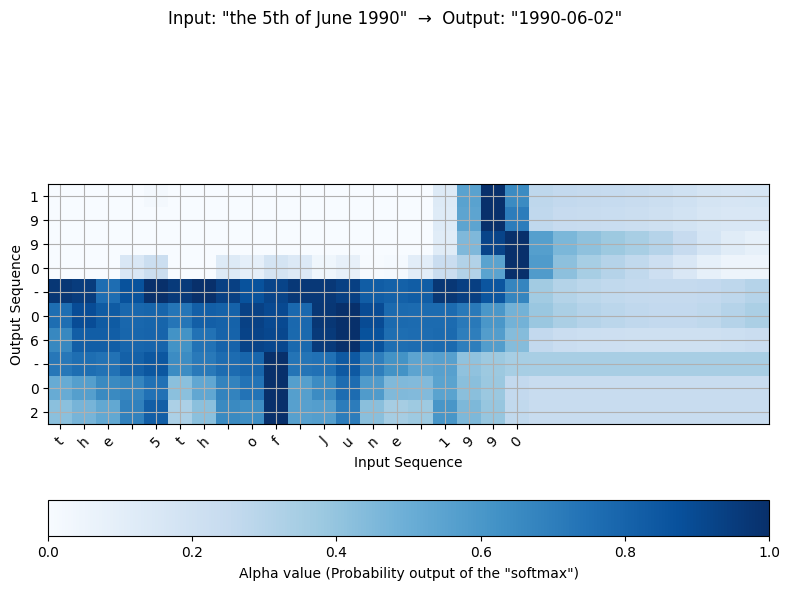

In [60]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "the 5th of June 1990", num = 7, n_s = 64)

## Save the Model

In [43]:
# Save the model in HDF5 (.h5) format
model.save('model.h5')

# Save the model in native Keras (.keras) format
model.save('model.keras', save_format='keras')